# SED-ML script (python examples)


In [36]:
import roadrunner
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def full_selection(model):
    """ Make full selection for integration. """
    species_ids = model.model.getBoundarySpeciesIds() + model.model.getFloatingSpeciesIds()
    return ["time"] + species_ids + [f'[{sid}]' for sid in species_ids] \
        + model.model.getReactionIds() + model.model.getCompartmentIds()

def model(path):
    return roadrunner.RoadRunner(path)

def uniform(model, start, end, steps):
    s = model.simulate(start, end, steps)
    return pd.DataFrame(s, columns=s.colnames)

def onestep(model, end):
    s = model.simulate(0, end, steps=1)
    df = pd.DataFrame(s, columns=s.colnames)
    return df.tail(1)

class dotdict(dict):
    """dot.notation access to dictionary attributes.
    Special dicts needed.
    """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Comparisons
```
  model1 = model("BIOMD0000000021.xml")
  model2 = model1
  model2.V_mT = 0.28
  model2.V_dT = 4.8
  task1 = model1.uniform(0, 380, 1000)
  task2 = model2.uniform(0, 380, 1000)
  p1 = plot(task1.time, [task1.Mt, task2.Mt])
  p2 = plot(task1.Cn, task1.Mt)
  p2.addPlot(task2.Cn, task2.Mt)

  p1.show()
  p2.show()
```

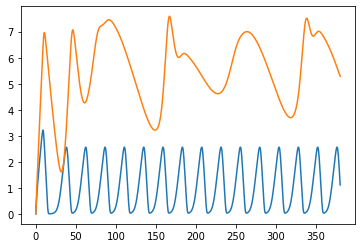

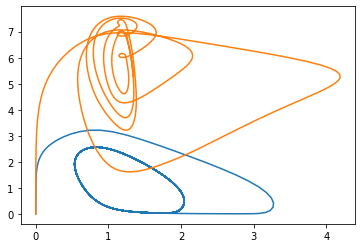

In [32]:
model1 = model("BIOMD0000000021.xml")
# FIXME: copy of roadrunner objects not possible 
# (see reported issue https://github.com/sys-bio/roadrunner/issues/469)
# We have to reload here
# model2 = model1
model2 = model("BIOMD0000000021.xml")
model2.V_mT = 0.28
model2.V_dT = 4.8

# FIXME: necessary to define what is collected!
# any defaults here? (time and species amounts/concentrations? for SBML)
model1.timeCourseSelections = full_selection(model1)

# unclear what 1000 is (steps or points, being explicit here)
task1 = uniform(model1, start=0, end=380, steps=1000)
task2 = uniform(model2, start=0, end=380, steps=1000)

# FIXME: how to access amounts and concentrations?
fig, p1 = plt.subplots()
# p1 is an axes! stacking the vectors to plot at the same time
p1.plot(task1.time, np.stack([task1['[Mt]'], task2['[Mt]']], axis=1))

fig, p2 = plt.subplots()
p2.plot(task1['[Cn]'], task1['[Mt]'])
p2.plot(task2['[Cn]'], task2['[Mt]'])
plt.show()

## Perturbations
```
  model1 = model("oscli.xml")
  task1 = {"time" : range(0, 10.1, 0.1), "S1" : [], "S2", [], "J0_v0", []}
  for x in task1.time:
    if(x>=4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    model1.onestep(0.1)
    for element in ['S1', 'S2', 'J0_v0']:
        task1[element].append(model1[element])
  plot(task1.time, [task1.S1, task1.S2, task1.J0_v0])
```

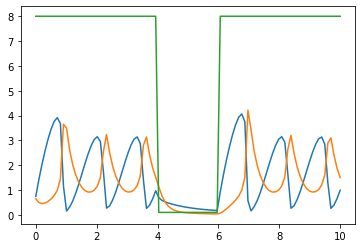

In [39]:
model1 = model("oscli.xml")
model1.timeCourseSelections = ["time", "S1", "S2", "J0_v0"]

# FIXME: basic vectors ! linspace, logspace, zeros_like, ones_like
time = np.linspace(start=0, stop=10, num=100)
task1 = dotdict({
    "time" : time,
    "S1" : np.zeros_like(time), 
    "S2" : np.zeros_like(time), 
    "J0_v0": np.zeros_like(time)
})
# enumerate is very powerful! access to indices
for k, x in enumerate(task1["time"]):
    if (x >= 4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    # FIXME: the results have to be returned (are not in the model)
    s = onestep(model1, 0.1)
    # FIXME: unclear amount/concentration
    for element in ['S1', 'S2', 'J0_v0']:
        # doing via index not via append
        task1[element][k] = s[element]

plt.plot(task1.time, np.stack([task1.S1, task1.S2, task1.J0_v0], axis=1))
plt.show()